# Active Appearance Models - Basics
This notebook provides a basic tutorial on Active Appearance Models (AAMs). AAMs are generative parametric models that describe the shape and appearance of a certain object class; e.g. the human face. In a typical application, these models are matched against input images to obtain the set of parameters that best describe a particular instance of the object being modelled.

The aim of this short notebook is to showcase how one can build and fit AAMs to images using ``menpo`` and ``menpofit``. It includes the following sections:

1. Acquiring data
2. Loading and visualizing data
3. Building a simple AAM
4. Fit a simple AAM

## 1. Acquiring data

AAMs are typically build from a large collection of annotated images. In this notebook we will build AAMs from annotated images of the human face and, consequently, this is the object our AAMs will model.

The Breaking Bad image in `Menpo`'s data folder is a good example of this kind of annotated images:

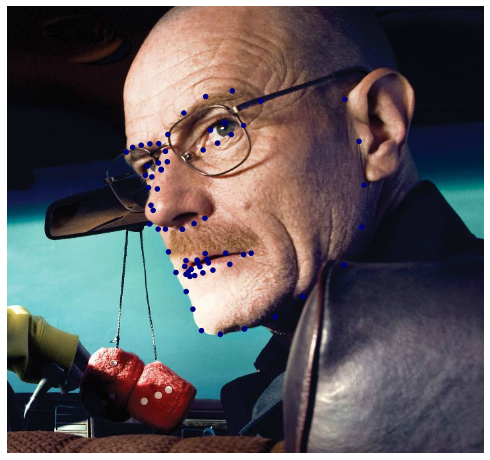

In [2]:
%matplotlib inline

import menpo.io as mio

breakingbad = mio.import_builtin_asset.breakingbad_jpg()
breakingbad = breakingbad.crop_to_landmarks_proportion(0.5)
breakingbad.view_landmarks();

In this notebook, we will build AAMs using one of the most popular and widely used annotated facial databases, the Labeled Faces Parts in the Wild (LFPW) database. Both images and corresponding facial landmark annotations are publicly available and can be downloaded from the following link: 

* http://ibug.doc.ic.ac.uk/download/annotations/lfpw.zip/ 

In order to continue with this notebook, the user is required to simply: 
 
* Click on the previous link.
* Fill out the form with his/her details. 
* Proceed to download the LFPW database. 
* Unzip and save the LFPW database to a location of his/her like.
* Paste the path to the local copy of the LFPW database on the next cell.
 
Note that the `.zip` file containing the whole annotated database is of approximately 350MB.

In [3]:
path_to_lfpw = '/vol/atlas/databases/lfpw/'

## 2. Loading and visualizing data

The first step in building our AAM will be to import all the images and annotations of the training set of LFPW database. Luckily, `Menpo`'s `io` module allows us to do exactly that using only a few lines of code:

In [4]:
import menpo.io as mio

training_images = []
# load landmarked images
for i in mio.import_images(path_to_lfpw + 'trainset/*', verbose=True):
    # crop image
    i.crop_to_landmarks_proportion_inplace(0.1)
    # convert it to greyscale if needed
    if i.n_channels == 3:
        i = i.as_greyscale(mode='luminosity')
    # append it to the list
    training_images.append(i)

Importing assets: [==========] 100% (811/811) - 00:00:00 remaining


The previous cell loads all the images of the LFPW together with their corresponding landmark annotations.

Note that here the images are cropped in order to save some valuable memory space and, for simplicity, also converted to greyscale.

The `Menpo` ecosystem is well equiped with a series of predefined IPython Notebook widgets for the most common data visualization tasks. In order to check if the data has been correctly imported we will use the ``visualize_images`` widget.

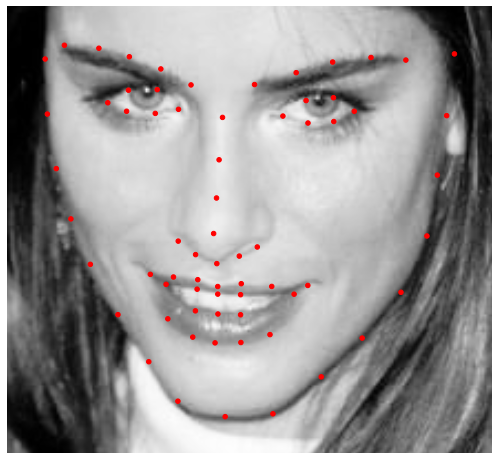

In [5]:
from menpo.visualize import visualize_images

visualize_images(training_images)

## 3. Building a simple AAM

Deformable models, in general, and AAMs, in particular, are a one of the core concept of `Menpo` and all efforts have been put to facilitate their usage. In fact, given a list of training images, an AAM can be built using a single line of code.

In [6]:
from menpofit.aam import AAMBuilder
from menpo.feature import no_op

# build AAM
aam = AAMBuilder(features=no_op, 
                 normalization_diagonal=120, 
                 n_levels=1).build(training_images, verbose=True)

- Normalizing images size: Done
- Building model
  - Done


Note that here we import a feature to use from `menpo.features`. In this very basic case we actually do not want to use a feature at all - so we use the special `no_op` feature that does nothing. Features are in general required to get good fitting performance, hence the default `feature_type` is actually `igo`.

As first class citizens of `Menpo`, AAMs can be printed just like any other `Menpo` object (e.g. `Images` or `PointClouds)`:

In [7]:
print(aam)

Active Appearance Model
 - 811 training images.
 - DifferentiablePiecewiseAffine Warp.
 - No pyramid used:
   - Feature is no_op with 1 channel per image.
   - Reference frame of length 5353 (5353 x 1C, 89W x 88H x 1C)
   - 133 shape components (100.00% of variance)
   - 810 appearance components (100.00% of variance)



Printing an AAM is the easiest way to retrieve its specific characteristics. For example, printing the previous AAM tells us that it was build from 811 images among several other things.

AAMs also define an instance method that allows us to generate novel AAM instances by applying a set of particular weights to the components of their shape and apperance models:

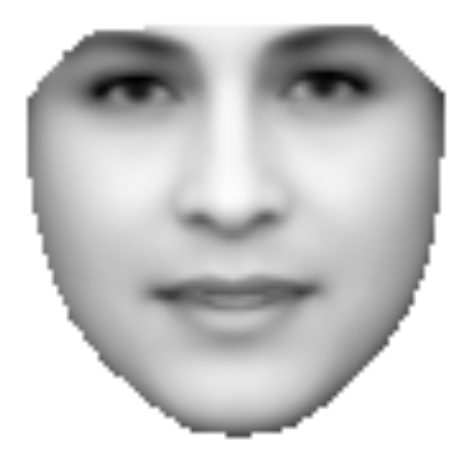

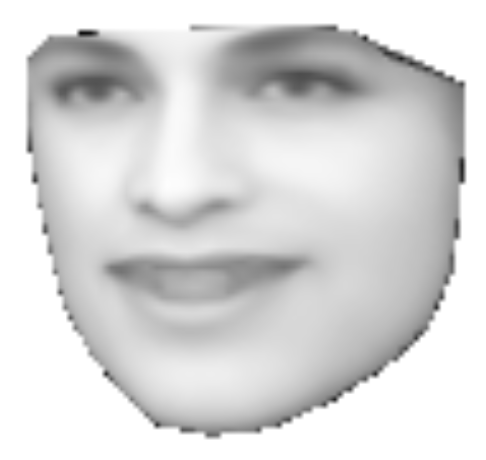

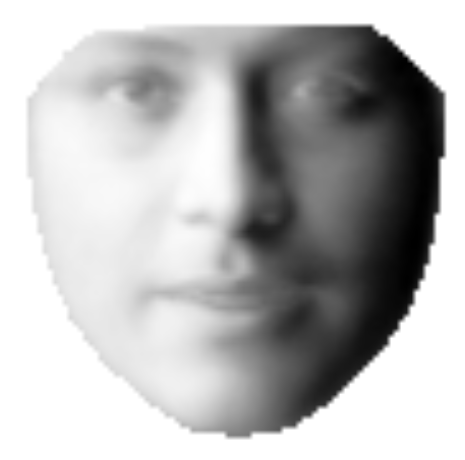

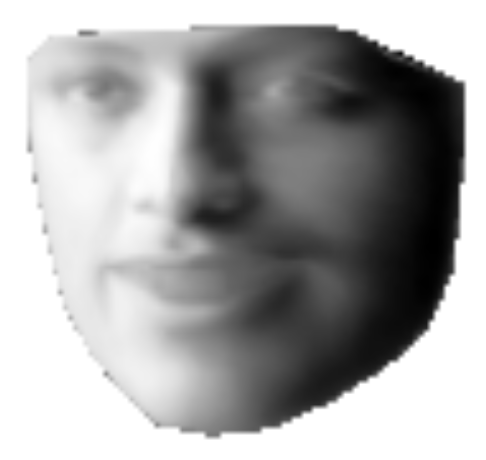

In [8]:
# using default parameters
aam.instance().view();

# varying shape parameters
aam.instance(shape_weights=[1.0, 0.5, -2.1]).view(new_figure=True);

# varying appearance parameters
aam.instance(appearance_weights=[2.7, 3.5, 0.9]).view(new_figure=True);

# varying both
aam.instance(shape_weights=[1.0, 0.5, -2.1], appearance_weights=[2.7, 3.5, 0.9]).view(new_figure=True);

Furthermore, ``menpofit`` is equiped with a powerfull widget that allow us to explore AAMs:

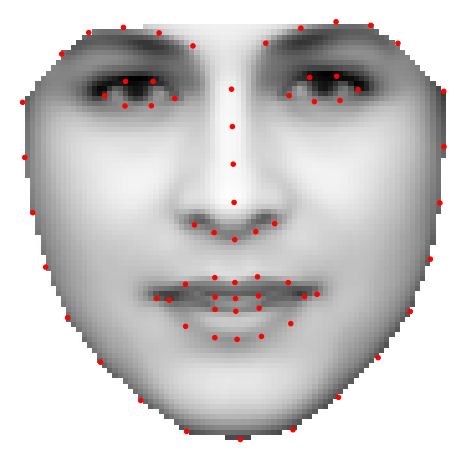

In [9]:
aam.view_aam_widget()

You can also independently visualize the shape and the appearance models using widgets

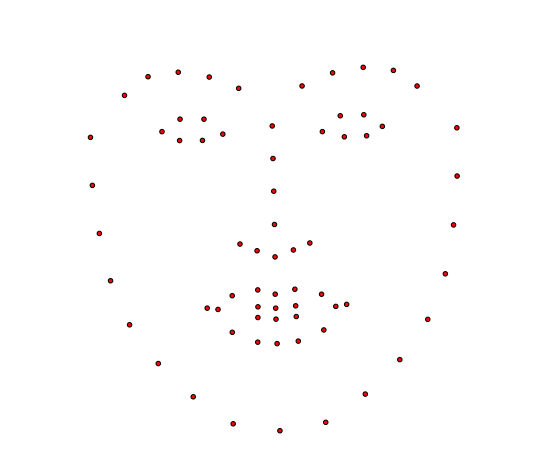

In [10]:
aam.view_shape_models_widget()

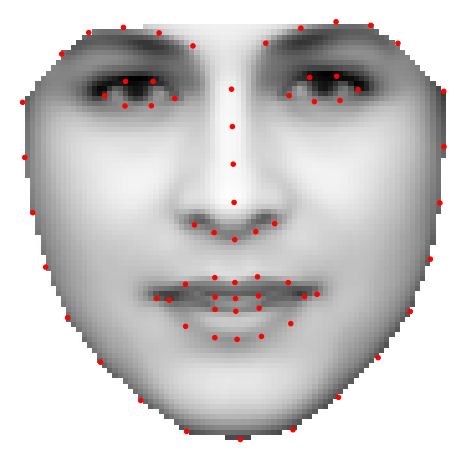

In [11]:
aam.view_appearance_models_widget()

## 4. Fit a simple AAM 

In `Menpo`, AAMs can be fitted to images by creating `Fitter` objects around them. 

One of the most popular and well known family of algorithms for fitting AAMs is the one based around the original `Lucas-Kanade` algorithm for Image Alignment. In order to fit our AAM using an algorithms of the previous family, `Menpo` allows the user to define a `LucasKanadeAAmFitter` object. Again, using a single line of code!!!

In [12]:
from menpofit.aam import LucasKanadeAAMFitter

# define Lucas-Kanade based AAM fitter
fitter = LucasKanadeAAMFitter(aam, n_shape=0.9, n_appearance=0.9)

The previous cell has created a `LucasKanadeAAMFitter` that will fit images using 90% of the variance present on the AAM's shape and appearance models and that will use the default `LucasKanade` algorithm (i.e. the `Alternating Inverse Compositional` algorithm) for fitting AAMs.

It is also important to know that these `LucasKanadeAAMFitter` objects are also first class citizen in `Menpo` and, consequently, can be printed:

In [13]:
print(fitter)

Active Appearance Model Fitter
 - Lucas-Kanade Simultaneous-IC
 - Transform is OrthoMDTransform and residual is SSD.
 - 811 training images.
 - No pyramid used:
   - Feature is no_op with 1 channel per image.
   - Reference frame of length 5353 (5353 x 1C, 89W x 88H x 1C)
   - 12 motion parameters
   - 32 appearance components (90.08% of original variance)



Fitting a `LucasKanadeAAMFitter` to an image is as simple as calling its `fit` method. Let's try it by fitting some images of the LFPW database test set!!!

In [14]:
# load test images
test_images = []
for i in mio.import_images(path_to_lfpw + 'testset/*', max_images=5, verbose=True):
    # crop image
    i.crop_to_landmarks_proportion_inplace(0.5)
    # convert it to grayscale if needed
    if i.n_channels == 3:
        i = i.as_greyscale(mode='luminosity')
    # append it to the list
    test_images.append(i)

Importing assets: [==========] 100% (5/5) - 00:00:00 remaining


Note that for the purpose of this simple fitting demonstration we will just fit the first 5 images of the LFPW test set.

In [15]:
fitting_results = []

# fit images
for j, i in enumerate(test_images):
    
    # obtain groubnd truth (original) landmarks
    gt_s = i.landmarks['PTS'].lms
    
    # generate initialization landmarks
    initial_s = fitter.perturb_shape(gt_s, noise_std=0.02)
    
    # fit image
    fr = fitter.fit(i, initial_s, gt_shape=gt_s)
    
    # append fitting result to list
    fitting_results.append(fr)
    
    # print image numebr
    print('Image: {}'.format(j))
    
    # print fitting error
    print(fr)

Image: 0
Fitting Result
 - Initial error: 0.0397
 - Final error: 0.0279
 - LK-AAM-Simultaneous-IC method with 1 pyramid levels, 50 iterations and using no_op features.
Image: 1
Fitting Result
 - Initial error: 0.0581
 - Final error: 0.0232
 - LK-AAM-Simultaneous-IC method with 1 pyramid levels, 50 iterations and using no_op features.
Image: 2
Fitting Result
 - Initial error: 0.0271
 - Final error: 0.0332
 - LK-AAM-Simultaneous-IC method with 1 pyramid levels, 50 iterations and using no_op features.
Image: 3
Fitting Result
 - Initial error: 0.0447
 - Final error: 0.0305
 - LK-AAM-Simultaneous-IC method with 1 pyramid levels, 50 iterations and using no_op features.
Image: 4
Fitting Result
 - Initial error: 0.0671
 - Final error: 0.0959
 - LK-AAM-Simultaneous-IC method with 1 pyramid levels, 50 iterations and using no_op features.


`Menpo`'s `Fitter` objects save the result of their fittings using Menpo's `FittingResult` objects. Being a `Fitter` object itself, the `LucasKanadeAAMFitter` is no exception to the rule and, consequently, the result obtained by executing the previous cell is a list of `FittingResult` objects.

`FittingResult` objects are core `Menpo` objects that allow the user to print, visualize and analyse the results produced by `Fitter` objects. Like all `Menpo`'s core objects `FittingResult` are printable. Note that, they were printed inside of the previous fitting  loop in order to display the final fitting error for each fitted image.

Apart from being printable, `FittingResult` objects also allow the user to quickly visualize the initial shape from which the fitting algorithm started from and the final fitting result:

In [16]:
fr = fitting_results[1]

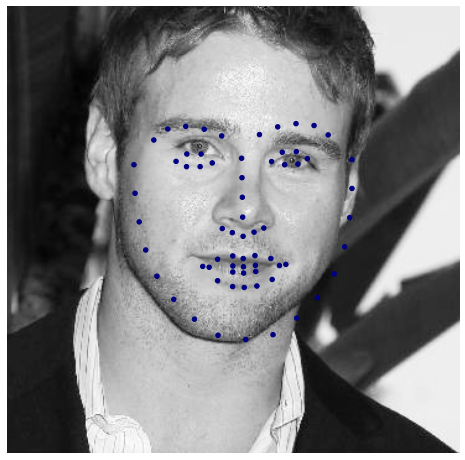

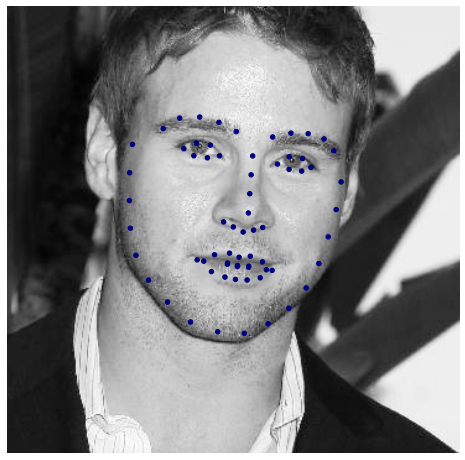

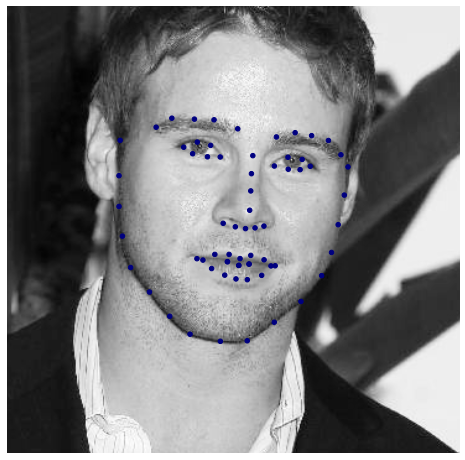

In [17]:
# visualize initialization
fr.fitted_image.view_landmarks(group='initial')
# visualize final result
fr.fitted_image.view_landmarks(new_figure=True, group='final')
# visualize ground truth 
fr.fitted_image.view_landmarks(new_figure=True, group='ground')

Again, there exist a `menpofit` IPython Notebook widget that facilitates the visualization of `FittingResult`.

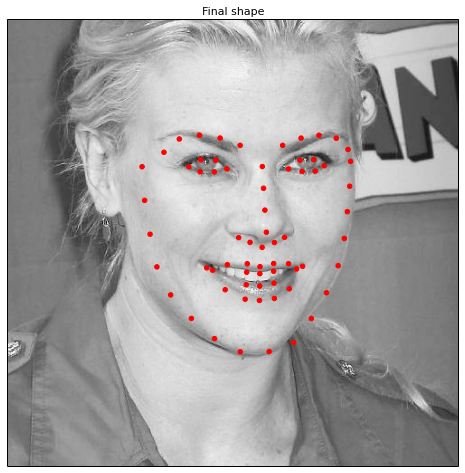

In [19]:
from menpofit.visualize import visualize_fitting_result

visualize_fitting_result(fitting_results)